
## Acknowledgements
Special thanks to ChatGPT for providing code snippets and guidance for the implementation of various techniques in this project. 
[OpenAI’s ChatGPT](https://www.openai.com/chatgpt) was instrumental in generating code and answering questions about data analysis and 
visualization.


In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import librosa
#import parselmouth
#from parselmouth.praat import call
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
#from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram
import IPython.display as Ipd

import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
import args
from dataset import *
from models import *
from train_yamnet_features import *
from fairness_metrics import *

warnings.filterwarnings("ignore", category=UserWarning, message="PySoundFile failed. Trying audioread instead.")
warnings.filterwarnings("ignore", category=FutureWarning, message="librosa.core.audio.__audioread_load")


# Preparing the dataset

In [4]:
def visulize_metrics_NN(model_to_test_, best_model_weight_, data_dir = './../data/bids_with_sensitive_recordings/',target_diagnosis = 'voc_fold_paralysis'):
    
    dataset = VBAIDataset(data_dir)
    person_session_pairs = get_person_session_pairs(dataset)
    
    model_dir = os.path.join('./..', 'saved_models', model_to_test_)
    test_identities = np.load(os.path.join(model_dir, 'test_ids.npy'))
    
    test_dataset = MyAudioDataset(test_identities,dataset,person_session_pairs,diagnosis_column=target_diagnosis,algo='DL')
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    #test_data_labels = np.load(os.path.join(model_dir, 'test_gt_pred.npy'))
    #test_gts = test_data_labels[0]
    #model_preds = test_data_labels[1] 
    # this might not be the predictions from the best models.
    # check the tensorboard logs to find out the best model weights
    
    print("Test data size : ", len(test_dataset))
    
    test_dataset.set_algorithm_type('DT')
    opensmile_df_test,feature_cols,label_cols = create_open_smile_df(test_dataset,include_GAS=True,diagnosis_column=target_diagnosis)
    test_dataset.set_algorithm_type('DL')

    # load and test the model
    model = get_models(args=None,spec_gram=False)
    model.load_state_dict(torch.load(os.path.join(model_dir, best_model_weight_)))
    binary_crs_entropy_ls = torch.nn.BCELoss(reduction='none')
    
    device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        test_ls,test_acc,model_preds,ground_truths = train_epoch(model = model, epoch = 0, mode = "Test", data_loader = test_loader, device = device,
                                                                 loss_func = binary_crs_entropy_ls, optimizer = None, scheduler = None, writer = None)
    
    # print/plot metrics
    _, _, _print_string_ = chi_DIR_plot(test_dataset,opensmile_df_test,ground_truths,model_preds,attribute='gender',writer=None,calc_chi_square=False)
    print(_print_string_)
    print()
    equalized_metrics(opensmile_df_test,ground_truths,model_preds,attribute='gender',writer=None)
    
    _, _, _print_string_ = chi_DIR_plot(test_dataset,opensmile_df_test,ground_truths,model_preds,attribute='site',writer=None)
    print(_print_string_)
    print()
    equalized_metrics(opensmile_df_test,ground_truths,model_preds,attribute='site',writer=None)
    
    _, _, _print_string_ = chi_DIR_plot(test_dataset,opensmile_df_test,ground_truths,model_preds,attribute='age',writer=None)
    print(_print_string_)
    print()
    equalized_metrics(opensmile_df_test,ground_truths,model_preds,attribute='AGE_bin',writer=None)


Test data size :  449


Epoch 0,Test: 100%|███████████████████████████████████| 4/4 [00:00<00:00, 13.69batch/s, Acc=0.85, Lss=0.43]


--- GENDER ---
                         TP   FP    FN     TN       TPR  FPR
Female gender identity  2.0  0.0  28.0  263.0  0.066667  0.0
Male gender identity    0.0  0.0  38.0  118.0  0.000000  0.0


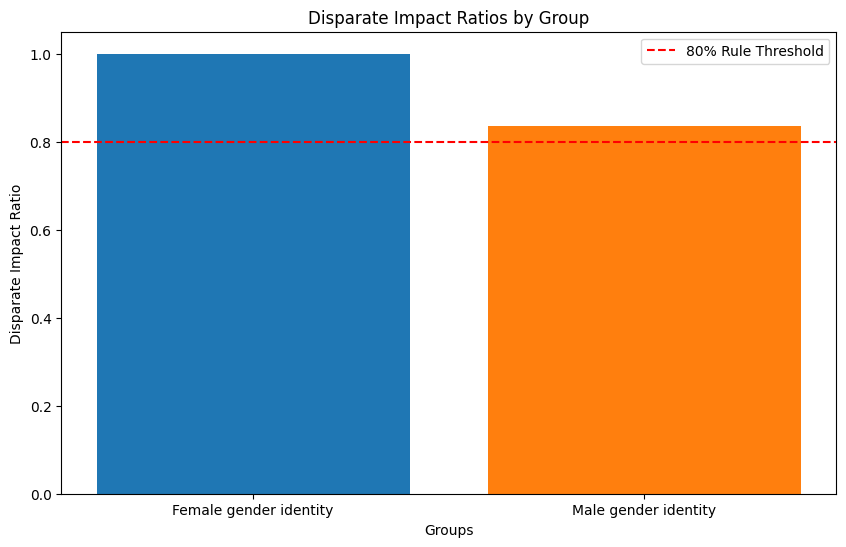

Disparate Impact Ratio for Group Female gender identity: 1.0
Disparate Impact Ratio for Group Male gender identity: 0.8363328495403967


--- GENDER ---
    tp   fp     tn    fn    sens  spec  ppv     npv       j      f1       mcc  \
0  2.0  0.0  381.0  66.0  0.0294   1.0  1.0  0.8523  0.0294  0.0571  0.158332   

   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.147  0.0  0.0       68.0        2.0      -66.0        -0.9706  

Equalized ODDs

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0 0.0000
   1.0  0.0 0.0667

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  0.0
   1.0  0.0  0.0

And loss is 0.1514

Equal Opportunity

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0 0.0000
   1.0  0.0 0.0667

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  0.0
   1.0  0.0  0.0

And loss is 0.1514

--- SITE ---
            TP   FP    FN     TN       TPR  FPR
MIT        0.0

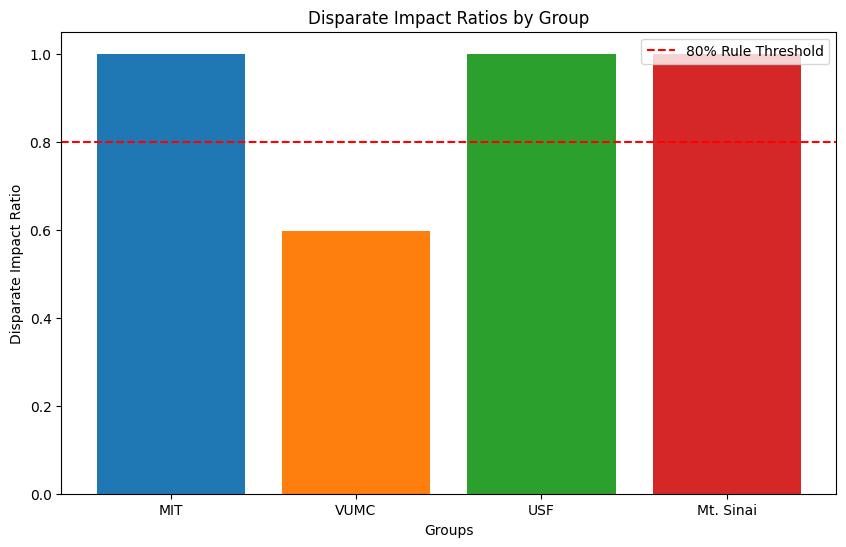

Chi-Square Statistic: nan, p-value: nan
Independent
Disparate Impact Ratio for Group MIT: 1.0
Disparate Impact Ratio for Group VUMC: 0.5975609756097561
Disparate Impact Ratio for Group USF: 1.0
Disparate Impact Ratio for Group Mt. Sinai: 1.0


--- SITE ---
    tp   fp     tn    fn    sens  spec  ppv     npv       j      f1       mcc  \
0  2.0  0.0  381.0  66.0  0.0294   1.0  1.0  0.8523  0.0294  0.0571  0.158332   

   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.147  0.0  0.0       68.0        2.0      -66.0        -0.9706  

Equalized ODDs

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0    NaN
   1.0  0.0 0.0294
   2.0  0.0    NaN
   3.0  0.0    NaN

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  NaN
   1.0  0.0  0.0
   2.0  0.0  NaN
   3.0  0.0  NaN

And loss is 0.1514

Equal Opportunity

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0    NaN
   1.0  0.0 0.0294
   2.0  0.0    NaN
   3.0 

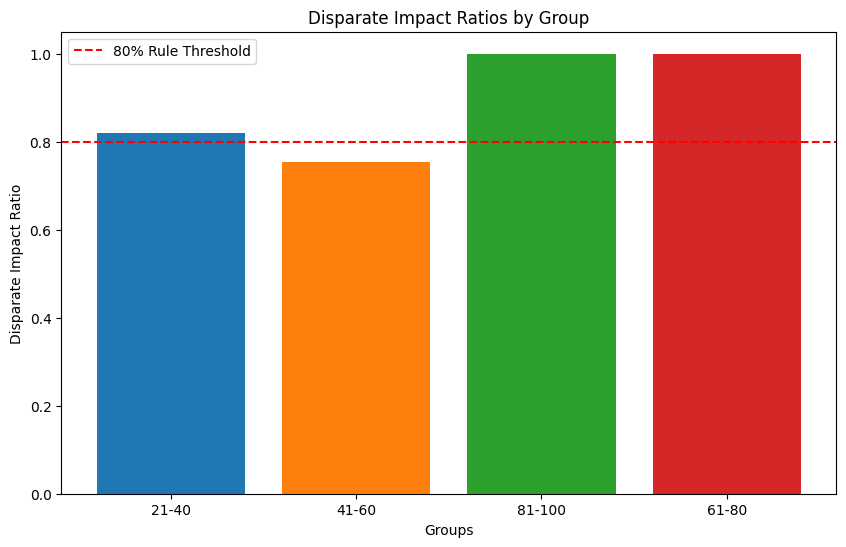

Chi-Square Statistic: nan, p-value: nan
Independent
Disparate Impact Ratio for Group 21-40: 0.8205128205128205
Disparate Impact Ratio for Group 41-60: 0.7548387096774194
Disparate Impact Ratio for Group 81-100: 1.0
Disparate Impact Ratio for Group 61-80: 1.0


--- AGE_BIN ---
    tp   fp     tn    fn    sens  spec  ppv     npv       j      f1       mcc  \
0  2.0  0.0  381.0  66.0  0.0294   1.0  1.0  0.8523  0.0294  0.0571  0.158332   

   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.147  0.0  0.0       68.0        2.0      -66.0        -0.9706  

Equalized ODDs

Pre-adjustment group rates are 

 group  fpr    tpr
   1.0  0.0 0.0667
   2.0  0.0 0.0000
   3.0  0.0    NaN
   4.0  0.0    NaN

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   1.0  0.0  0.0
   2.0  0.0  0.0
   3.0  0.0  NaN
   4.0  0.0  NaN

And loss is 0.1514

Equal Opportunity

Pre-adjustment group rates are 

 group  fpr    tpr
   1.0  0.0 0.0667
   2.0  0.0 0.0000
   3.0

In [6]:
model_to_test = 'test_5'
best_model_weight = 'best_model_epoch_66.pth'

visulize_metrics_NN(model_to_test, best_model_weight)

--- GENDER ---
                         TP   FP    FN     TN       TPR  FPR
Female gender identity  2.0  0.0  28.0  263.0  0.066667  0.0
Male gender identity    0.0  0.0  38.0  118.0  0.000000  0.0


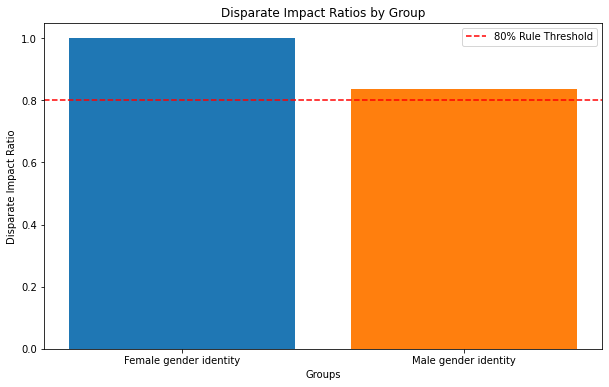

Disparate Impact Ratio for Group Female gender identity: 1.0
Disparate Impact Ratio for Group Male gender identity: 0.8363328495403967


--- GENDER ---
    tp   fp     tn    fn    sens  spec  ppv     npv       j      f1       mcc  \
0  2.0  0.0  381.0  66.0  0.0294   1.0  1.0  0.8523  0.0294  0.0571  0.158332   

   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.147  0.0  0.0       68.0        2.0      -66.0        -0.9706  

Equalized ODDs

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0 0.0000
   1.0  0.0 0.0667

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  0.0
   1.0  0.0  0.0

And loss is 0.1514

Equal Opportunity

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0 0.0000
   1.0  0.0 0.0667

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  0.0
   1.0  0.0  0.0

And loss is 0.1514



--- SITE ---
            TP   FP    FN     TN       TPR  FPR
MIT        0.0  0.0   0.0   90.0       NaN  0.0
VUMC       2.0  0.0  66.0   96.0  0.029412  0.0
USF        0.0  0.0   0.0  121.0       NaN  0.0
Mt. Sinai  0.0  0.0   0.0   74.0       NaN  0.0


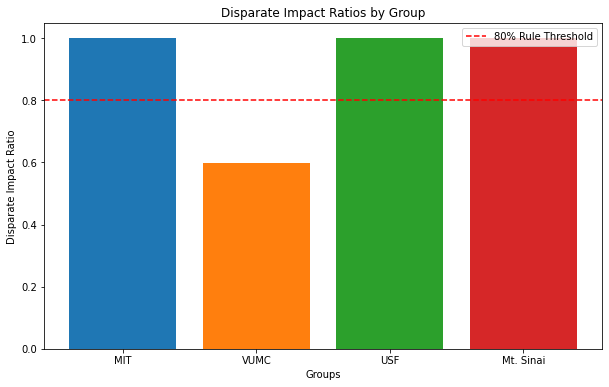

Chi-Square Statistic: nan, p-value: nan
Independent
Disparate Impact Ratio for Group MIT: 1.0
Disparate Impact Ratio for Group VUMC: 0.5975609756097561
Disparate Impact Ratio for Group USF: 1.0
Disparate Impact Ratio for Group Mt. Sinai: 1.0


--- SITE ---
    tp   fp     tn    fn    sens  spec  ppv     npv       j      f1       mcc  \
0  2.0  0.0  381.0  66.0  0.0294   1.0  1.0  0.8523  0.0294  0.0571  0.158332   

   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.147  0.0  0.0       68.0        2.0      -66.0        -0.9706  

Equalized ODDs

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0    NaN
   1.0  0.0 0.0294
   2.0  0.0    NaN
   3.0  0.0    NaN

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   0.0  0.0  NaN
   1.0  0.0  0.0
   2.0  0.0  NaN
   3.0  0.0  NaN

And loss is 0.1514

Equal Opportunity

Pre-adjustment group rates are 

 group  fpr    tpr
   0.0  0.0    NaN
   1.0  0.0 0.0294
   2.0  0.0    NaN
   3.0 

--- AGE ---
         TP   FP    FN     TN       TPR  FPR
21-40   2.0  0.0  28.0  126.0  0.066667  0.0
41-60   0.0  0.0  38.0  117.0  0.000000  0.0
81-100  0.0  0.0   0.0   71.0       NaN  0.0
61-80   0.0  0.0   0.0   67.0       NaN  0.0


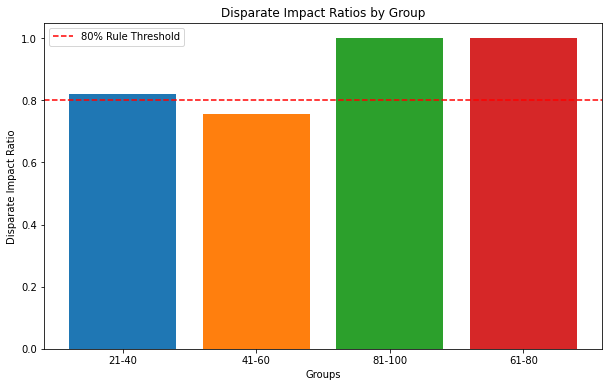

Chi-Square Statistic: nan, p-value: nan
Independent
Disparate Impact Ratio for Group 21-40: 0.8205128205128205
Disparate Impact Ratio for Group 41-60: 0.7548387096774194
Disparate Impact Ratio for Group 81-100: 1.0
Disparate Impact Ratio for Group 61-80: 1.0


--- AGE_BIN ---
    tp   fp     tn    fn    sens  spec  ppv     npv       j      f1       mcc  \
0  2.0  0.0  381.0  66.0  0.0294   1.0  1.0  0.8523  0.0294  0.0571  0.158332   

   brier  auc   ap  true_prev  pred_prev  prev_diff  rel_prev_diff  
0  0.147  0.0  0.0       68.0        2.0      -66.0        -0.9706  

Equalized ODDs

Pre-adjustment group rates are 

 group  fpr    tpr
   1.0  0.0 0.0667
   2.0  0.0 0.0000
   3.0  0.0    NaN
   4.0  0.0    NaN

And loss is 0.1470


Post-adjustment group rates are 

 group  fpr  tpr
   1.0  0.0  0.0
   2.0  0.0  0.0
   3.0  0.0  NaN
   4.0  0.0  NaN

And loss is 0.1514

Equal Opportunity

Pre-adjustment group rates are 

 group  fpr    tpr
   1.0  0.0 0.0667
   2.0  0.0 0.0000
   3.0